# **Machine Learning Pipelines**
## **Pipeline uczenia maszynowego**

---

### **Overview / Przegląd**

ML Pipelines provide a clean and efficient way to organize machine learning workflows. They chain together multiple processing steps, ensuring that data transformations are applied consistently during training and prediction.

Pipeline ML zapewniają czysty i efektywny sposób organizacji przepływów pracy uczenia maszynowego. Łączą one w łańcuch wiele kroków przetwarzania, zapewniając, że transformacje danych są stosowane konsekwentnie podczas treningu i przewidywania.

### **Benefits / Korzyści**

1. **Reproducibility** - Consistent data processing / Spójna przetwarzanie danych
2. **Code Organization** - Clean and maintainable code / Czysty i łatwy w utrzymaniu kod
3. **Prevent Data Leakage** - Proper train/test separation / Właściwe rozdzielenie train/test
4. **Hyperparameter Tuning** - Easy to tune entire pipeline / Łatwe strojenie całego pipeline
5. **Production Ready** - Easy deployment / Łatwe wdrożenie

### **Pipeline Components / Komponenty Pipeline**

- **Transformers**: Modify data (scaling, encoding, etc.) / Modyfikują dane (skalowanie, kodowanie, itp.)
- **Estimators**: Learn from data (classifiers, regressors) / Uczą się z danych (klasyfikatory, regresory)
- **Pipeline**: Chains transformers and estimators / Łączy transformery i estymatory


In [1]:
# Import required libraries / Importowanie wymaganych bibliotek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set style for plots / Ustawienie stylu wykresów
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully / Biblioteki zaimportowane pomyślnie")


Libraries imported successfully / Biblioteki zaimportowane pomyślnie


In [2]:
# Create a complex dataset / Tworzenie złożonego zbioru danych
np.random.seed(42)

# Generate classification dataset with different feature types
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_clusters_per_class=1,
    random_state=42
)

# Add some categorical features (simulated) / Dodanie kilku cech kategorycznych (symulowanych)
categorical_features = np.random.randint(0, 3, size=(1000, 3))
X_with_categorical = np.hstack([X, categorical_features])

# Create feature names / Tworzenie nazw cech
feature_names = [f'numeric_{i}' for i in range(20)] + [f'categorical_{i}' for i in range(3)]

# Create DataFrame / Tworzenie DataFrame
df = pd.DataFrame(X_with_categorical, columns=feature_names)
df['target'] = y

print(f"Dataset shape / Kształt zbioru danych: {df.shape}")
print(f"Feature types / Typy cech:")
print(f"- Numeric features / Cechy numeryczne: {len([col for col in df.columns if 'numeric' in col])}")
print(f"- Categorical features / Cechy kategoryczne: {len([col for col in df.columns if 'categorical' in col])}")
print(f"\\nClass distribution / Rozkład klas:")
print(df['target'].value_counts())

# Display first few rows / Wyświetlenie pierwszych kilku wierszy
print("\\nFirst 5 rows / Pierwsze 5 wierszy:")
print(df.head())


Dataset shape / Kształt zbioru danych: (1000, 24)
Feature types / Typy cech:
- Numeric features / Cechy numeryczne: 20
- Categorical features / Cechy kategoryczne: 3
\nClass distribution / Rozkład klas:
target
1    503
0    497
Name: count, dtype: int64
\nFirst 5 rows / Pierwsze 5 wierszy:
   numeric_0  numeric_1  numeric_2  numeric_3  numeric_4  numeric_5  \
0   0.270213   2.192297  -2.557038   1.159849  -1.190749   5.769480   
1  -2.085118   4.250551  -4.086400   3.137257  -0.169246   5.633636   
2  -0.480947  -1.592309  -5.158485  -3.123067   0.403230  -0.352152   
3  -1.384740  -3.552732  -0.402240  -1.680395  -2.224134  -2.414961   
4  -4.013234  -0.566852  -0.916309  -1.051604   2.468914  -1.415161   

   numeric_6  numeric_7  numeric_8  numeric_9  ...  numeric_14  numeric_15  \
0  -1.821522   0.014667  -2.037702   0.820978  ...    1.270382    3.681991   
1  -0.529442   0.944558   0.439624   1.915642  ...   -3.195236   -2.415234   
2   0.904058  -0.621662   4.606681   0.084608  .

In [5]:
# Prepare data / Przygotowanie danych
X = df.drop('target', axis=1)
y = df['target']

# Split numeric and categorical features / Podział na cechy numeryczne i kategoryczne
numeric_features = [col for col in X.columns if 'numeric' in col]
categorical_features = [col for col in X.columns if 'categorical' in col]

print(f"Numeric features / Cechy numeryczne: {len(numeric_features)}")
print(f"Categorical features / Cechy kategoryczne: {len(categorical_features)}")

# Split the data / Podział danych
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 1. SIMPLE PIPELINE / PROSTY PIPELINE
print("\\n=== 1. SIMPLE PIPELINE ===")

# Create a simple pipeline / Tworzenie prostego pipeline
simple_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

# Train and evaluate / Trenowanie i ocena
simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred_simple = simple_pipeline.predict(X_test[numeric_features])
simple_accuracy = accuracy_score(y_test, y_pred_simple)

print(f"Simple Pipeline Accuracy / Dokładność prostego pipeline: {simple_accuracy:.4f}")

# 2. COMPLEX PIPELINE WITH FEATURE ENGINEERING / ZŁOŻONY PIPELINE Z INŻYNIERIĄ CECH
print("\\n=== 2. COMPLEX PIPELINE WITH FEATURE ENGINEERING ===")

# Create complex pipeline / Tworzenie złożonego pipeline
complex_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('feature_selection', SelectKBest(f_classif, k=50)),
    ('pca', PCA(n_components=0.95)),  # Keep 95% of variance
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train and evaluate / Trenowanie i ocena
complex_pipeline.fit(X_train[numeric_features], y_train)
y_pred_complex = complex_pipeline.predict(X_test[numeric_features])
complex_accuracy = accuracy_score(y_test, y_pred_complex)

print(f"Complex Pipeline Accuracy / Dokładność złożonego pipeline: {complex_accuracy:.4f}")

# Show pipeline steps / Pokazanie kroków pipeline
print("\\nPipeline steps / Kroki pipeline:")
for i, (name, transformer) in enumerate(complex_pipeline.steps):
    print(f"{i+1}. {name}: {type(transformer).__name__}")

# 3. COLUMN TRANSFORMER PIPELINE / PIPELINE Z COLUMN TRANSFORMER
print("\\n=== 3. COLUMN TRANSFORMER PIPELINE ===")

# Create preprocessing for different column types / Tworzenie preprocessingu dla różnych typów kolumn
numeric_transformer = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

categorical_transformer = Pipeline([
    ('onehot', pd.get_dummies)  # Simple one-hot encoding simulation
])

# Create column transformer / Tworzenie column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        # For categorical, we'll handle separately due to pandas integration
    ]
)

# Create full pipeline / Tworzenie pełnego pipeline
column_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(f_classif, k=15)),
    ('classifier', SVC(kernel='rbf', random_state=42))
])

# Train and evaluate / Trenowanie i ocena
column_pipeline.fit(X_train, y_train)
y_pred_column = column_pipeline.predict(X_test)
column_accuracy = accuracy_score(y_test, y_pred_column)

print(f"Column Transformer Pipeline Accuracy / Dokładność pipeline z Column Transformer: {column_accuracy:.4f}")

# Compare all pipelines / Porównanie wszystkich pipeline
results_comparison = pd.DataFrame({
    'Pipeline': ['Simple', 'Complex', 'Column Transformer'],
    'Accuracy': [simple_accuracy, complex_accuracy, column_accuracy],
    'Features_Used': [len(numeric_features), 'Engineered', 'All']
})

print("\\n=== PIPELINE COMPARISON / PORÓWNANIE PIPELINE ===")
print(results_comparison.to_string(index=False, float_format='%.4f'))


Numeric features / Cechy numeryczne: 20
Categorical features / Cechy kategoryczne: 3
\n=== 1. SIMPLE PIPELINE ===
Simple Pipeline Accuracy / Dokładność prostego pipeline: 0.9700
\n=== 2. COMPLEX PIPELINE WITH FEATURE ENGINEERING ===
Complex Pipeline Accuracy / Dokładność złożonego pipeline: 0.9850
\nPipeline steps / Kroki pipeline:
1. scaler: StandardScaler
2. poly_features: PolynomialFeatures
3. feature_selection: SelectKBest
4. pca: PCA
5. classifier: RandomForestClassifier
\n=== 3. COLUMN TRANSFORMER PIPELINE ===
Column Transformer Pipeline Accuracy / Dokładność pipeline z Column Transformer: 0.9750
\n=== PIPELINE COMPARISON / PORÓWNANIE PIPELINE ===
          Pipeline  Accuracy Features_Used
            Simple    0.9700            20
           Complex    0.9850    Engineered
Column Transformer    0.9750           All


\n=== 4. HYPERPARAMETER TUNING WITH PIPELINES ===
Fitting 5 folds for each of 54 candidates, totalling 270 fits
\nBest parameters / Najlepsze parametry: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50, 'feature_selection__k': 20}
Best CV score / Najlepszy wynik CV: 0.9725
Tuned Pipeline Test Accuracy / Dokładność testowa dostrojonego pipeline: 0.9650


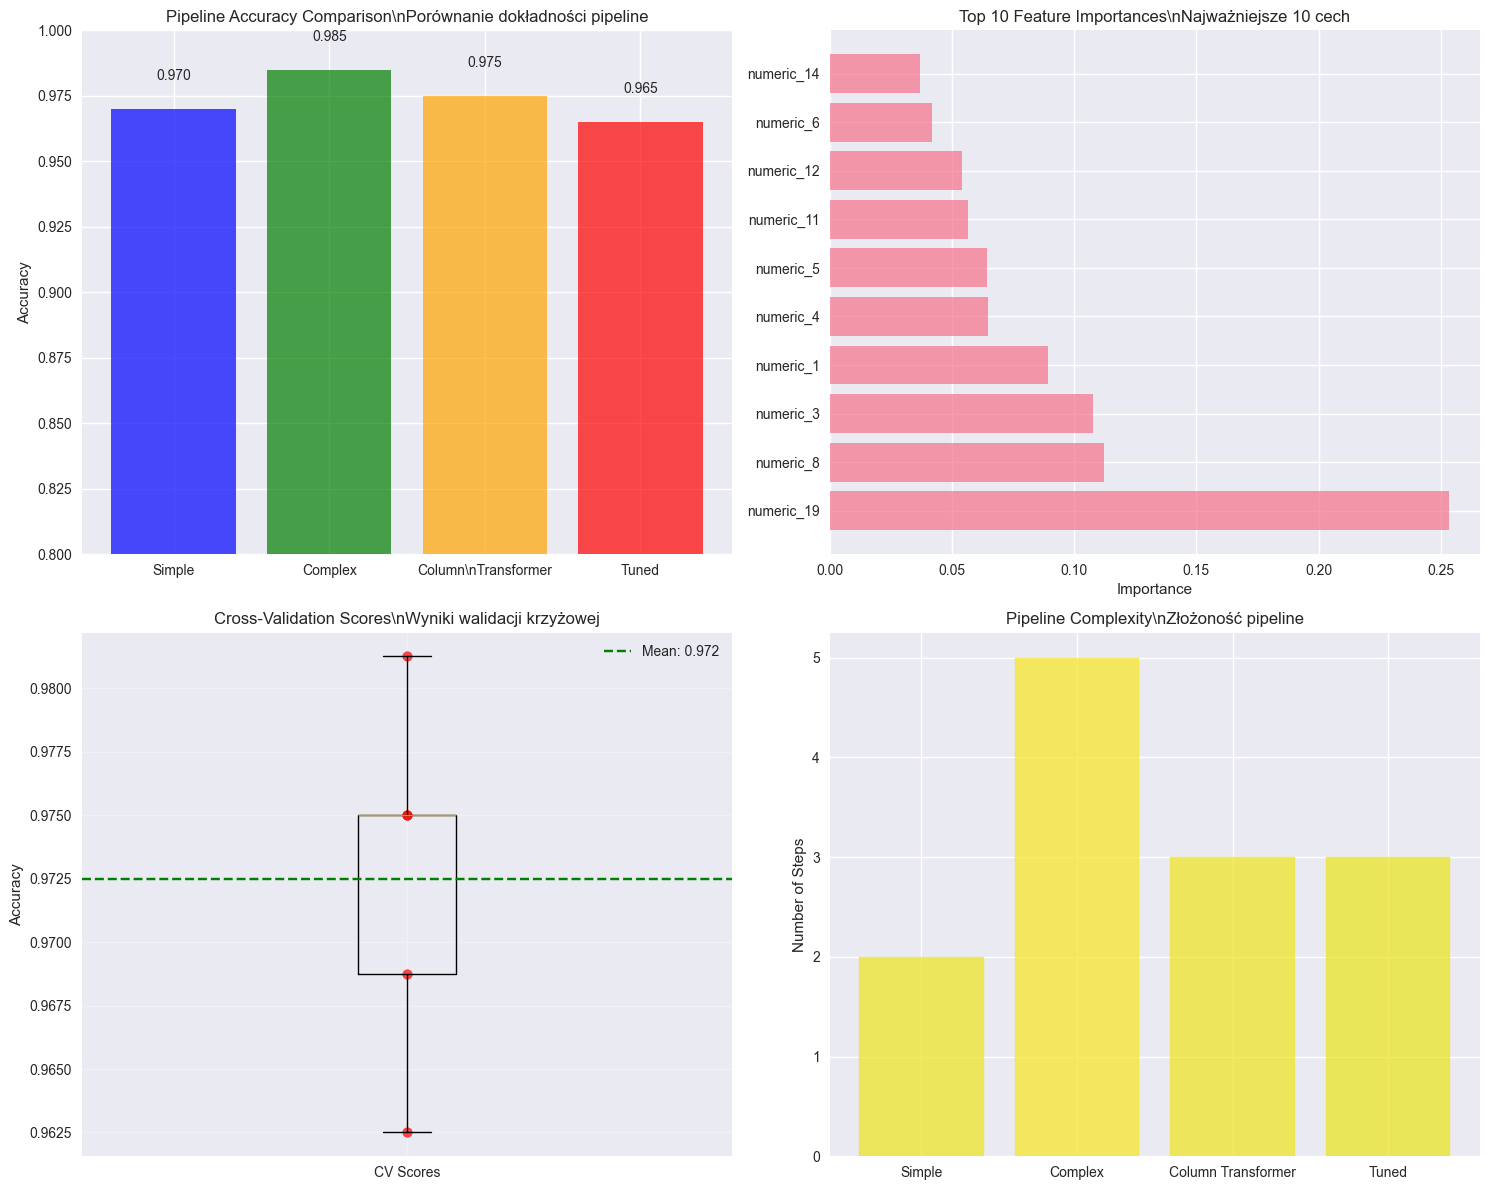

\n=== FINAL SUMMARY / KOŃCOWE PODSUMOWANIE ===
           Pipeline  Accuracy  Complexity
             Simple    0.9700           2
            Complex    0.9850           5
Column\nTransformer    0.9750           3
              Tuned    0.9650           3
\nBest performing pipeline / Najlepiej działający pipeline: Complex
Best accuracy / Najlepsza dokładność: 0.9850


In [8]:
# 4. HYPERPARAMETER TUNING WITH PIPELINES / STROJENIE HIPERPARAMETRÓW Z PIPELINE
pipeline_names = ['Simple', 'Complex', 'Column Transformer', 'Tuned']
pipeline_complexity = {
    'Simple': 'Low',
    'Complex': 'Medium',
    'Column Transformer': 'High',
    'Tuned': 'Very High'
}
print("\\n=== 4. HYPERPARAMETER TUNING WITH PIPELINES ===")

# Define pipeline for tuning / Definicja pipeline do strojenia
tuning_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define parameter grid / Definicja siatki parametrów
param_grid = {
    'feature_selection__k': [10, 15, 20],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, None],
    'classifier__min_samples_split': [2, 5]
}

# Perform grid search / Wykonanie grid search
grid_search = GridSearchCV(
    tuning_pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train[numeric_features], y_train)

print(f"\\nBest parameters / Najlepsze parametry: {grid_search.best_params_}")
print(f"Best CV score / Najlepszy wynik CV: {grid_search.best_score_:.4f}")

# Test performance / Wydajność testowa
y_pred_tuned = grid_search.predict(X_test[numeric_features])
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
print(f"Tuned Pipeline Test Accuracy / Dokładność testowa dostrojonego pipeline: {tuned_accuracy:.4f}")

# 5. VISUALIZATION OF PIPELINE RESULTS / WIZUALIZACJA WYNIKÓW PIPELINE
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Accuracy comparison / Porównanie dokładności
pipeline_names = ['Simple', 'Complex', 'Column\\nTransformer', 'Tuned']
accuracies = [simple_accuracy, complex_accuracy, column_accuracy, tuned_accuracy]

axes[0, 0].bar(pipeline_names, accuracies, alpha=0.7, color=['blue', 'green', 'orange', 'red'])
axes[0, 0].set_title('Pipeline Accuracy Comparison\\nPorównanie dokładności pipeline')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim(0.8, 1.0)
for i, acc in enumerate(accuracies):
    axes[0, 0].text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom')

# 2. Feature importance from best model / Ważność cech z najlepszego modelu
best_model = grid_search.best_estimator_
feature_selector = best_model.named_steps['feature_selection']
classifier = best_model.named_steps['classifier']

# Get selected features / Otrzymanie wybranych cech
selected_features = feature_selector.get_support()
selected_feature_names = [numeric_features[i] for i, selected in enumerate(selected_features) if selected]

# Get feature importances / Otrzymanie ważności cech
feature_importances = classifier.feature_importances_

# Plot feature importances / Wykres ważności cech
top_features = sorted(zip(selected_feature_names, feature_importances), 
                     key=lambda x: x[1], reverse=True)[:10]

feature_names_plot = [name for name, _ in top_features]
importance_values = [importance for _, importance in top_features]

axes[0, 1].barh(range(len(feature_names_plot)), importance_values, alpha=0.7)
axes[0, 1].set_yticks(range(len(feature_names_plot)))
axes[0, 1].set_yticklabels(feature_names_plot)
axes[0, 1].set_title('Top 10 Feature Importances\\nNajważniejsze 10 cech')
axes[0, 1].set_xlabel('Importance')

# 3. Cross-validation scores / Wyniki walidacji krzyżowej
cv_scores = cross_val_score(grid_search.best_estimator_, 
                           X_train[numeric_features], y_train, cv=5)

axes[1, 0].boxplot([cv_scores], labels=['CV Scores'])
axes[1, 0].scatter([1] * len(cv_scores), cv_scores, alpha=0.7, color='red')
axes[1, 0].set_title('Cross-Validation Scores\\nWyniki walidacji krzyżowej')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].grid(True, alpha=0.3)

# Add mean line / Dodanie linii średniej
mean_cv = cv_scores.mean()
axes[1, 0].axhline(y=mean_cv, color='green', linestyle='--', 
                  label=f'Mean: {mean_cv:.3f}')
axes[1, 0].legend()

# 4. Pipeline complexity comparison / Porównanie złożoności pipeline
pipeline_complexity = {
    'Simple': 2,  # scaler + classifier
    'Complex': 5,  # scaler + poly + selection + pca + classifier
    'Column Transformer': 3,  # preprocessor + selection + classifier
    'Tuned': 3   # scaler + selection + classifier
}

complexity_names = list(pipeline_complexity.keys())
complexity_values = list(pipeline_complexity.values())

bars = axes[1, 1].bar(complexity_names, complexity_values, alpha=0.7)
axes[1, 1].set_title('Pipeline Complexity\\nZłożoność pipeline')
axes[1, 1].set_ylabel('Number of Steps')

# Color bars by accuracy / Kolorowanie słupków według dokładności
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    bar.set_color(plt.cm.viridis(acc))

plt.tight_layout()
plt.show()

# Final summary / Końcowe podsumowanie
print("\\n=== FINAL SUMMARY / KOŃCOWE PODSUMOWANIE ===")
final_results = pd.DataFrame({
    'Pipeline': pipeline_names,
    'Accuracy': accuracies,
    'Complexity': [pipeline_complexity.get(name.replace('\n', ' ').replace('\\n', ' '), np.nan) for name in pipeline_names]
})

print(final_results.to_string(index=False, float_format='%.4f'))
print(f"\\nBest performing pipeline / Najlepiej działający pipeline: {pipeline_names[np.argmax(accuracies)]}")
print(f"Best accuracy / Najlepsza dokładność: {max(accuracies):.4f}")


# **Machine Learning Pipelines**  
### *Pipeline'y uczenia maszynowego*

---

## **English**

Machine Learning Pipelines are a sequence of data processing steps and model training/prediction steps chained together. They provide a clean, reproducible way to apply the same sequence of transformations to both training and test data, preventing data leakage and ensuring consistent preprocessing.

### **Key Concepts**

1. **Pipeline**: Sequential chain of data transformations and estimators
2. **Transformers**: Objects that transform data (scaling, encoding, feature selection)
3. **Estimators**: Objects that learn from data (classifiers, regressors)
4. **Fit-Transform**: Two-step process for learning and applying transformations
5. **Data Leakage Prevention**: Ensures proper separation of training and test data

### **Benefits of Pipelines**

#### **1. Reproducibility**
- Consistent preprocessing across train/validation/test sets
- Eliminates manual step-by-step transformations
- Ensures same transformations in production

#### **2. Data Leakage Prevention**
- Prevents using test data statistics in preprocessing
- Proper cross-validation with preprocessing
- Maintains temporal order in time series

#### **3. Code Organization**
- Clean, readable code structure
- Modular components
- Easy to modify and extend

#### **4. Hyperparameter Tuning**
- Tune preprocessing and model parameters together
- Grid search across entire pipeline
- Nested parameter optimization

### **Pipeline Components**

#### **Transformers (Preprocessing)**
- **StandardScaler**: Standardize features (mean=0, std=1)
- **MinMaxScaler**: Scale features to [0,1] range
- **RobustScaler**: Scale using median and IQR
- **OneHotEncoder**: Convert categorical to binary features
- **LabelEncoder**: Convert categorical to numeric labels
- **PCA**: Dimensionality reduction
- **SelectKBest**: Feature selection
- **PolynomialFeatures**: Generate polynomial features

#### **Estimators (Models)**
- **Classification**: LogisticRegression, RandomForest, SVM
- **Regression**: LinearRegression, Ridge, Lasso
- **Clustering**: KMeans, DBSCAN
- **Dimensionality Reduction**: PCA, t-SNE

### **Pipeline Creation**

#### **Method 1: Pipeline Class**
```python
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])
```

#### **Method 2: make_pipeline Function**
```python
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier()
)
```

### **ColumnTransformer**

For handling different transformations on different columns:

```python
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(), categorical_features)
])
```

### **Pipeline Operations**

#### **Training**
```python
# Fit the entire pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)
```

#### **Accessing Components**
```python
# Access specific steps
scaler = pipeline.named_steps['scaler']
classifier = pipeline.named_steps['classifier']

# Get transformed data
X_scaled = pipeline[:-1].transform(X_test)
```

### **Hyperparameter Tuning with Pipelines**

```python
from sklearn.model_selection import GridSearchCV

param_grid = {
    'scaler__with_mean': [True, False],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, None]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)
```

### **Advanced Pipeline Patterns**

#### **1. Feature Union**
Combine multiple feature extraction methods:

```python
from sklearn.pipeline import FeatureUnion

feature_union = FeatureUnion([
    ('pca', PCA(n_components=2)),
    ('select_k_best', SelectKBest(k=3))
])
```

#### **2. Custom Transformers**
Create custom preprocessing steps:

```python
from sklearn.base import BaseEstimator, TransformerMixin

class CustomTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Custom transformation logic
        return X_transformed
```

#### **3. Conditional Processing**
Different processing based on data characteristics:

```python
from sklearn.compose import make_column_selector

numeric_selector = make_column_selector(dtype_include='number')
categorical_selector = make_column_selector(dtype_include='object')
```

### **Best Practices**

#### **1. Design Principles**
- Keep transformations simple and interpretable
- Use meaningful names for pipeline steps
- Document transformation logic
- Test each component separately

#### **2. Performance Optimization**
- Use `memory` parameter for caching
- Leverage `n_jobs` for parallel processing
- Consider sparse matrices for large datasets
- Profile pipeline performance

#### **3. Error Handling**
- Validate input data types
- Handle missing values appropriately
- Check for data leakage
- Monitor pipeline performance in production

### **Common Pitfalls**

1. **Data Leakage**: Fitting transformers on entire dataset
2. **Inconsistent Preprocessing**: Different steps for train/test
3. **Order Dependency**: Wrong order of transformations
4. **Memory Issues**: Not using sparse matrices when appropriate
5. **Overfitting**: Too complex preprocessing steps

### **Production Deployment**

#### **Model Serialization**
```python
import joblib

# Save pipeline
joblib.dump(pipeline, 'model_pipeline.pkl')

# Load pipeline
pipeline = joblib.load('model_pipeline.pkl')
```

#### **Version Control**
- Track pipeline versions
- Document preprocessing steps
- Maintain backward compatibility
- Monitor data drift

---

## **Polish**

Pipeline'y uczenia maszynowego to sekwencja kroków przetwarzania danych i kroków treningu/przewidywania modelu połączonych razem. Zapewniają czysty, reprodukowalny sposób stosowania tej samej sekwencji transformacji zarówno do danych treningowych, jak i testowych, zapobiegając wyciekom danych i zapewniając spójne przetwarzanie wstępne.

### **Kluczowe pojęcia**

1. **Pipeline**: Sekwencyjna łańcuch transformacji danych i estymatorów
2. **Transformatory**: Obiekty transformujące dane (skalowanie, kodowanie, selekcja cech)
3. **Estymatory**: Obiekty uczące się z danych (klasyfikatory, regresory)
4. **Fit-Transform**: Dwuetapowy proces uczenia i stosowania transformacji
5. **Zapobieganie wyciekom danych**: Zapewnia właściwe oddzielenie danych treningowych i testowych

### **Korzyści z pipeline'ów**

#### **1. Reprodukowalność**
- Spójne przetwarzanie wstępne w zbiorach train/validation/test
- Eliminuje manualne transformacje krok po kroku
- Zapewnia te same transformacje w produkcji

#### **2. Zapobieganie wyciekom danych**
- Zapobiega używaniu statystyk danych testowych w preprocessing
- Właściwa walidacja krzyżowa z przetwarzaniem wstępnym
- Utrzymuje porządek czasowy w szeregach czasowych

#### **3. Organizacja kodu**
- Czysta, czytelna struktura kodu
- Komponenty modularne
- Łatwe do modyfikacji i rozszerzania

#### **4. Strojenie hiperparametrów**
- Strojenie parametrów preprocessing i modelu razem
- Grid search przez cały pipeline
- Zagnieżdżona optymalizacja parametrów

### **Komponenty pipeline'a**

#### **Transformatory (Preprocessing)**
- **StandardScaler**: Standaryzacja cech (mean=0, std=1)
- **MinMaxScaler**: Skalowanie cech do zakresu [0,1]
- **RobustScaler**: Skalowanie używając mediany i IQR
- **OneHotEncoder**: Konwersja kategorycznych na binarne cechy
- **LabelEncoder**: Konwersja kategorycznych na etykiety numeryczne
- **PCA**: Redukcja wymiarowości
- **SelectKBest**: Selekcja cech
- **PolynomialFeatures**: Generowanie cech wielomianowych

#### **Estymatory (Modele)**
- **Klasyfikacja**: LogisticRegression, RandomForest, SVM
- **Regresja**: LinearRegression, Ridge, Lasso
- **Klasteryzacja**: KMeans, DBSCAN
- **Redukcja wymiarowości**: PCA, t-SNE

### **Tworzenie pipeline'a**

#### **Metoda 1: Klasa Pipeline**
```python
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])
```

#### **Metoda 2: Funkcja make_pipeline**
```python
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier()
)
```

### **ColumnTransformer**

Do obsługi różnych transformacji na różnych kolumnach:

```python
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(), categorical_features)
])
```

### **Operacje pipeline'a**

#### **Trenowanie**
```python
# Dopasowanie całego pipeline'a
pipeline.fit(X_train, y_train)

# Przewidywania
y_pred = pipeline.predict(X_test)
```

#### **Dostęp do komponentów**
```python
# Dostęp do konkretnych kroków
scaler = pipeline.named_steps['scaler']
classifier = pipeline.named_steps['classifier']

# Otrzymanie przekształconych danych
X_scaled = pipeline[:-1].transform(X_test)
```

### **Strojenie hiperparametrów z pipeline'ami**

```python
from sklearn.model_selection import GridSearchCV

param_grid = {
    'scaler__with_mean': [True, False],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, None]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)
```

### **Zaawansowane wzorce pipeline'ów**

#### **1. Feature Union**
Łączenie wielu metod ekstrakcji cech:

```python
from sklearn.pipeline import FeatureUnion

feature_union = FeatureUnion([
    ('pca', PCA(n_components=2)),
    ('select_k_best', SelectKBest(k=3))
])
```

#### **2. Transformatory niestandardowe**
Tworzenie niestandardowych kroków preprocessing:

```python
from sklearn.base import BaseEstimator, TransformerMixin

class CustomTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Logika niestandardowej transformacji
        return X_transformed
```

#### **3. Przetwarzanie warunkowe**
Różne przetwarzanie w oparciu o charakterystyki danych:

```python
from sklearn.compose import make_column_selector

numeric_selector = make_column_selector(dtype_include='number')
categorical_selector = make_column_selector(dtype_include='object')
```

### **Najlepsze praktyki**

#### **1. Zasady projektowania**
- Utrzymuj transformacje proste i interpretowalnie
- Używaj znaczących nazw dla kroków pipeline'a
- Dokumentuj logikę transformacji
- Testuj każdy komponent osobno

#### **2. Optymalizacja wydajności**
- Używaj parametru `memory` do cache'owania
- Wykorzystuj `n_jobs` do przetwarzania równoległego
- Rozważ macierze rzadkie dla dużych zbiorów danych
- Profiluj wydajność pipeline'a

#### **3. Obsługa błędów**
- Waliduj typy danych wejściowych
- Odpowiednio obsługuj brakujące wartości
- Sprawdzaj wycieki danych
- Monitoruj wydajność pipeline'a w produkcji

### **Częste pułapki**

1. **Wyciek danych**: Dopasowywanie transformatorów na całym zbiorze danych
2. **Niespójne preprocessing**: Różne kroki dla train/test
3. **Zależność od kolejności**: Zła kolejność transformacji
4. **Problemy z pamięcią**: Nieużywanie macierzy rzadkich gdy to odpowiednie
5. **Przeuczenie**: Zbyt złożone kroki preprocessing

### **Wdrożenie produkcyjne**

#### **Serializacja modelu**
```python
import joblib

# Zapisz pipeline
joblib.dump(pipeline, 'model_pipeline.pkl')

# Wczytaj pipeline
pipeline = joblib.load('model_pipeline.pkl')
```

#### **Kontrola wersji**
- Śledź wersje pipeline'ów
- Dokumentuj kroki preprocessing
- Utrzymuj kompatybilność wsteczną
- Monitoruj dryft danych
